## 57000 Project code

### Import module

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy
import math
from typing import Optional, List
from torch import Tensor
import torchvision.models as models
import os
from torch.nn import Parameter
import torch.utils.model_zoo as model_zoo
from pdb import set_trace as stop
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch.optim as optim
from tqdm import tqdm

#### Display the dataset

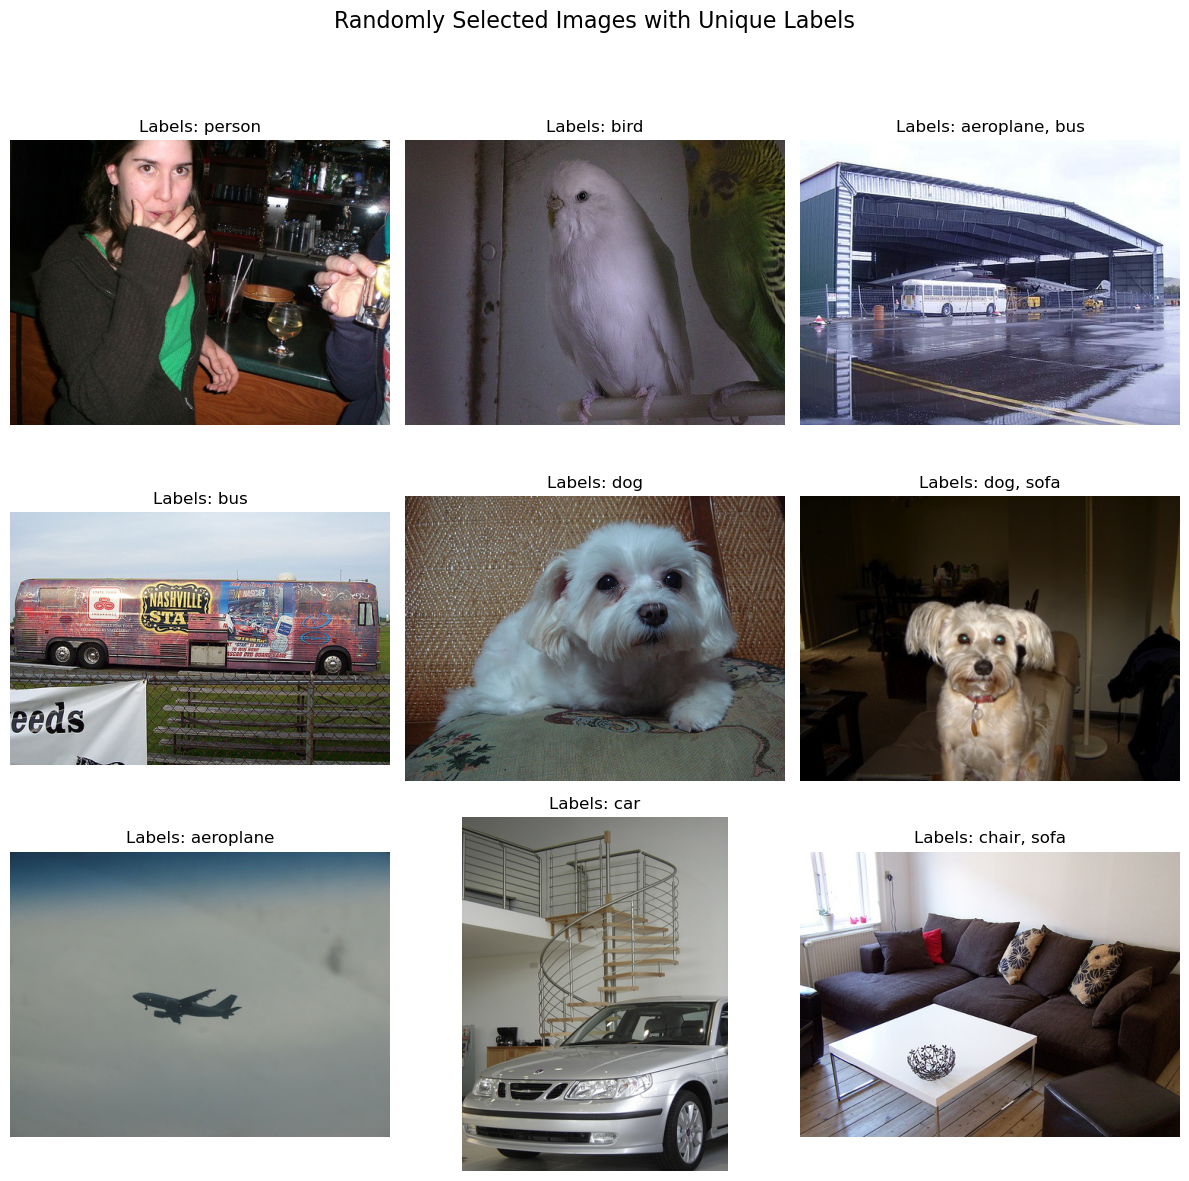

In [2]:
# Folder paths
annotations_path = r'voc\voc\VOCdevkit\VOC2007\Annotations'
images_path = r'voc\voc\VOCdevkit\VOC2007\JPEGImages'

def get_labels(annotation_file):
    """Extract labels from a single annotation file"""
    tree = ET.parse(annotation_file)
    root = tree.getroot()
    labels = set()  # Use a set to remove duplicates
    for obj in root.findall('object'):
        label = obj.find('name').text
        labels.add(label)
    return list(labels)  # Convert back to a list for display

# Get all image files in the JPEGImages folder
all_image_files = [f for f in os.listdir(images_path) if os.path.isfile(os.path.join(images_path, f))]

# Randomly select 9 images
selected_images = random.sample(all_image_files, 9)

# Create a 3x3 subplot layout
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle("Randomly Selected Images with Unique Labels", fontsize=16)

# Display each image with its labels
for i, image_file in enumerate(selected_images):
    row, col = divmod(i, 3)
    image_id, _ = os.path.splitext(image_file)
    annotation_file = os.path.join(annotations_path, f"{image_id}.xml")
    
    # Check if the corresponding annotation file exists
    if os.path.exists(annotation_file):
        # Get labels and remove duplicates
        labels = get_labels(annotation_file)
        labels_text = ', '.join(labels)
        
        # Open the image
        image_path = os.path.join(images_path, image_file)
        image = Image.open(image_path)
        
        # Display the image in the subplot
        axes[row, col].imshow(image)
        axes[row, col].set_title(f"Labels: {labels_text}")
        axes[row, col].axis('off')
    else:
        print(f"No annotation file found for {image_file}")

# Adjust spacing between subplots and display
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the distance between title and subplots
plt.show()


#### Dataloader

In [4]:
class Voc07Dataset(Dataset):
    def __init__(self, img_dir, anno_path, image_transform=None, labels_path=None, known_labels=0, testing=False, use_difficult=False):
        self.img_dir = img_dir
        self.image_transform = image_transform
        self.num_labels = 20  # PASCAL VOC 2007 has 20 classes
        self.known_labels = known_labels
        self.testing = testing
        self.use_difficult = use_difficult

        # Load image filenames
        with open(anno_path, 'r') as f:
            self.img_names = [line.strip() for line in f.readlines()]

        # Define PASCAL VOC category mapping
        self.category_info = {
            'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4,
            'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9,
            'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13,
            'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17,
            'train': 18, 'tvmonitor': 19
        }

        # Load labels
        self.labels = []
        for name in self.img_names:
            label_file = os.path.join(labels_path, name + '.xml')
            label_vector = self.parse_annotation(label_file)
            self.labels.append(label_vector)
        
        self.labels = np.array(self.labels).astype(int)

    def parse_annotation(self, label_file):
        label_vector = np.zeros(self.num_labels)
        tree = ET.parse(label_file)
        root = tree.getroot()
        for obj in root.findall('object'):
            # Skip objects marked as difficult
            if not self.use_difficult and obj.find('difficult').text == '1':
                continue
            class_name = obj.find('name').text.lower()
            if class_name in self.category_info:
                label_index = self.category_info[class_name]
                label_vector[label_index] = 1.0
        return label_vector

    def __getitem__(self, index):
        # Get image path and label
        img_name = self.img_names[index] + '.jpg'
        image = Image.open(os.path.join(self.img_dir, img_name)).convert('RGB')
        labels = torch.tensor(self.labels[index], dtype=torch.float32)

        # Apply image transformation
        if self.image_transform:
            image = self.image_transform(image)

        # Construct the mask
        mask = labels.clone()
        unk_mask_indices = self.get_unk_mask_indices()
        mask[unk_mask_indices] = -1

        sample = {
            'image': image,
            'labels': labels,
            'mask': mask,
            'imageIDs': img_name
        }
        return sample

    def __len__(self):
        return len(self.img_names)

    def get_unk_mask_indices(self):
        # Example mask index generation logic
        return np.random.choice(np.arange(self.num_labels), self.known_labels, replace=False)


# Paths and parameters
img_dir = 'voc/voc/VOCdevkit/VOC2007/JPEGImages'
anno_path = 'voc/voc/VOCdevkit/VOC2007/ImageSets/Main/trainval.txt'
labels_path = 'c:/Users/56372/Downloads/voc/voc/VOCdevkit/VOC2007/Annotations'

# Data augmentation and preprocessing
img_dir = 'voc/voc/VOCdevkit/VOC2007/JPEGImages'
labels_path = 'voc/voc/VOCdevkit/VOC2007/Annotations'
train_anno_path = 'voc/voc/VOCdevkit/VOC2007/ImageSets/Main/trainval.txt'
valid_anno_path = 'voc/voc/VOCdevkit/VOC2007/ImageSets/Main/val.txt'
test_anno_path = 'voc/voc/VOCdevkit/VOC2007/ImageSets/Main/test.txt'
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and data loaders
train_dataset = Voc07Dataset(img_dir=img_dir, anno_path=train_anno_path, image_transform=transform, labels_path=labels_path)
valid_dataset = Voc07Dataset(img_dir=img_dir, anno_path=valid_anno_path, image_transform=transform, labels_path=labels_path)
test_dataset = Voc07Dataset(img_dir=img_dir, anno_path=test_anno_path, image_transform=transform, labels_path=labels_path)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# # Save data
# def save_data(loader, filename):
#     data_list = []
#     for batch in loader:
#         data_list.append(batch)
#     torch.save(data_list, filename)

# # Save train, validation, and test data
# save_data(train_loader, 'train_data.pt')
# save_data(valid_loader, 'valid_data.pt')
# save_data(test_loader, 'test_data.pt')

# print("Data saved successfully.")


### Design the Multi-label classification model with Transformer

In [5]:
# Custom function
def custom_replace(tensor, on_neg_1, on_zero, on_one):
    res = tensor.clone()
    res[tensor == -1] = on_neg_1
    res[tensor == 0] = on_zero
    res[tensor == 1] = on_one
    return res

def get_activation_fn(activation):
    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu
    raise RuntimeError("activation should be relu/gelu, not {}".format(activation))

def weights_init(module):
    """Initialize the weights"""
    if isinstance(module, (nn.Linear, nn.Embedding)):
        stdv = 1. / math.sqrt(module.weight.size(1))
        module.weight.data.uniform_(-stdv, stdv)
    if isinstance(module, nn.Linear) and module.bias is not None:
        module.bias.data.uniform_(-stdv, stdv)
    elif isinstance(module, nn.LayerNorm):
        module.bias.data.zero_()
        module.weight.data.fill_(1.0)

# Model definition
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = get_activation_fn(activation)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        src2, attn = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src, attn

class SelfAttnLayer(nn.Module):
    def __init__(self, d_model, nhead=4, dropout=0.1):
        super().__init__()
        self.transformer_layer = TransformerEncoderLayer(d_model, nhead, d_model * 1, dropout=dropout, activation='relu')

    def forward(self, k, mask=None):
        k = k.transpose(0, 1)
        x, attn = self.transformer_layer(k, src_mask=mask)
        x = x.transpose(0, 1)
        return x, attn

class Backbone(nn.Module):
    def __init__(self):
        super(Backbone, self).__init__()
        self.base_network = models.resnet101(pretrained=True)
        self.base_network.avgpool = nn.AvgPool2d(kernel_size=7, stride=1, padding=0)

    def forward(self, images):
        x = self.base_network.conv1(images)
        x = self.base_network.bn1(x)
        x = self.base_network.relu(x)
        x = self.base_network.maxpool(x)
        x = self.base_network.layer1(x)
        x = self.base_network.layer2(x)
        x = self.base_network.layer3(x)
        x = self.base_network.layer4(x)
        return x

class CTranModel(nn.Module):
    def __init__(self, num_labels, use_lmt, pos_emb=False, layers=3, heads=4, dropout=0.1, no_x_features=False):
        super(CTranModel, self).__init__()
        self.use_lmt = use_lmt
        self.no_x_features = no_x_features

        self.backbone = Backbone()
        hidden = 2048

        self.label_input = torch.Tensor(np.arange(num_labels)).view(1, -1).long()
        self.label_lt = nn.Embedding(num_labels, hidden, padding_idx=None)

        self.known_label_lt = nn.Embedding(3, hidden, padding_idx=0)

        self.self_attn_layers = nn.ModuleList([SelfAttnLayer(hidden, heads, dropout) for _ in range(layers)])
        self.output_linear = nn.Linear(hidden, num_labels)
        self.LayerNorm = nn.LayerNorm(hidden)
        self.dropout = nn.Dropout(dropout)

        self.label_lt.apply(weights_init)
        self.known_label_lt.apply(weights_init)
        self.LayerNorm.apply(weights_init)
        self.self_attn_layers.apply(weights_init)
        self.output_linear.apply(weights_init)

    def forward(self, images, mask=None):
        const_label_input = self.label_input.repeat(images.size(0), 1).cuda()
        init_label_embeddings = self.label_lt(const_label_input)

        features = self.backbone(images)
        features = features.view(features.size(0), features.size(1), -1).permute(0, 2, 1)

        if self.use_lmt and mask is not None:
            # Apply custom_replace only when mask is not None
            label_feat_vec = custom_replace(mask, 0, 1, 2).long()
            state_embeddings = self.known_label_lt(label_feat_vec)
            init_label_embeddings += state_embeddings

        embeddings = torch.cat((features, init_label_embeddings), 1) if not self.no_x_features else init_label_embeddings
        embeddings = self.LayerNorm(embeddings)
        attns = []
        for layer in self.self_attn_layers:
            embeddings, attn = layer(embeddings, mask=None)
            attns.append(attn.detach().unsqueeze(0).data)

        label_embeddings = embeddings[:, -init_label_embeddings.size(1):, :]
        output = self.output_linear(label_embeddings)
        diag_mask = torch.eye(output.size(1)).unsqueeze(0).repeat(output.size(0), 1, 1).cuda()
        output = (output * diag_mask).sum(-1)

        return output, None, attns


#### Training Process of Transformers model without LMT

In [57]:
# Set paths
img_dir = 'voc/voc/VOCdevkit/VOC2007/JPEGImages'
labels_path = 'voc/voc/VOCdevkit/VOC2007/Annotations'
train_anno_path = 'voc/voc/VOCdevkit/VOC2007/ImageSets/Main/trainval.txt'
valid_anno_path = 'voc/voc/VOCdevkit/VOC2007/ImageSets/Main/val.txt'

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Instantiate datasets and data loaders
train_dataset = Voc07Dataset(img_dir=img_dir, anno_path=train_anno_path, image_transform=transform, labels_path=labels_path, known_labels=20)
valid_dataset = Voc07Dataset(img_dir=img_dir, anno_path=valid_anno_path, image_transform=transform, labels_path=labels_path, known_labels=20)
test_dataset = Voc07Dataset(img_dir=img_dir, anno_path=test_anno_path, image_transform=transform, labels_path=labels_path, known_labels=20)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize model
num_labels = 20
model = CTranModel(num_labels=num_labels, use_lmt=False, pos_emb=True)
model = model.cuda()

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Training and evaluation functions
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        images = batch['image'].cuda()
        labels = batch['labels'].cuda()

        optimizer.zero_grad()
        outputs, _, _ = model(images, labels)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    avg_loss = running_loss / len(dataloader)
    return avg_loss

def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].cuda()
            labels = batch['labels'].cuda()

            outputs, _, _ = model(images, labels)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    avg_loss = running_loss / len(dataloader)
    return avg_loss


# Open log file
log_file = 'training_log_withoutlmt.txt'
with open(log_file, 'w') as f:
    f.write("Epoch\tTrain Loss\tValidation Loss\n")

# Training loop
num_epochs = 20
best_val_loss = float('inf')
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss = evaluate(model, valid_loader, criterion)

    # Print and log to file
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.7f}, Validation Loss: {val_loss:.7f}")
    with open(log_file, 'a') as f:
        f.write(f"{epoch+1}\t{train_loss:.7f}\t{val_loss:.7f}\n")

    # Save the model with the lowest validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_withoutlmt.pt')
        print("Model saved with validation loss: {:.7f}".format(best_val_loss))

print("Training complete.")

c:\Users\56372\anaconda3\envs\ece60146\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\56372\anaconda3\envs\ece60146\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Train Loss: 0.1038667, Validation Loss: 0.0445148
Model saved with validation loss: 0.0445148
Epoch [2/20], Train Loss: 0.0500703, Validation Loss: 0.0257042
Model saved with validation loss: 0.0257042
Epoch [3/20], Train Loss: 0.0329693, Validation Loss: 0.0150991
Model saved with validation loss: 0.0150991
Epoch [4/20], Train Loss: 0.0221410, Validation Loss: 0.0105410
Model saved with validation loss: 0.0105410
Epoch [5/20], Train Loss: 0.0164365, Validation Loss: 0.0063604
Model saved with validation loss: 0.0063604
Epoch [6/20], Train Loss: 0.0114201, Validation Loss: 0.0047329
Model saved with validation loss: 0.0047329
Epoch [7/20], Train Loss: 0.0090893, Validation Loss: 0.0028174
Model saved with validation loss: 0.0028174
Epoch [8/20], Train Loss: 0.0072052, Validation Loss: 0.0026117
Model saved with validation loss: 0.0026117
Epoch [9/20], Train Loss: 0.0063425, Validation Loss: 0.0020516
Model saved with validation loss: 0.0020516
Epoch [10/20], Train Loss: 0

#### Display the training process of Transformers model without LMT

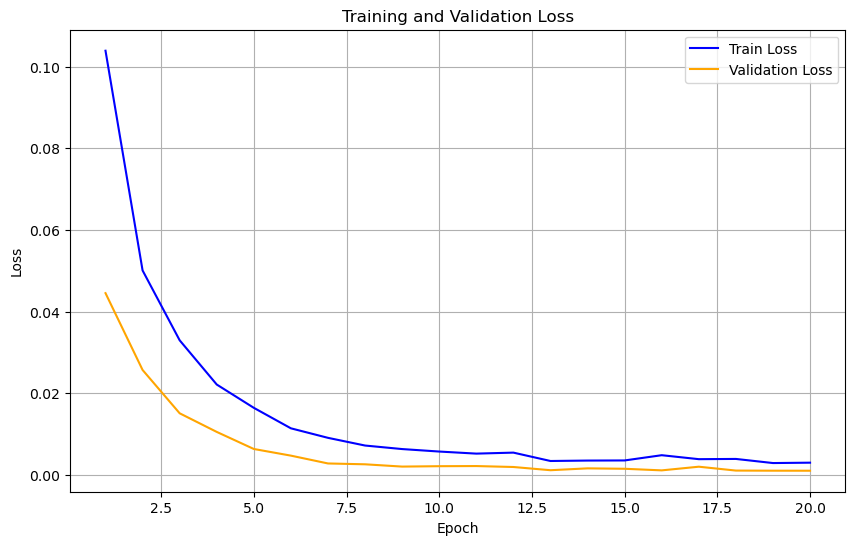

In [26]:
# Read the training log file
train_losses = []
val_losses = []
epochs = []

# Read the training log file
log_file = 'training_log_withoutlmt.txt'
with open(log_file, 'r') as f:
    next(f)  # Skip the header
    for line in f:
        epoch, train_loss, val_loss = line.strip().split('\t')
        epochs.append(int(epoch))
        train_losses.append(float(train_loss))
        val_losses.append(float(val_loss))

# Plot both training and validation losses on the same figure
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


#### Test the Transformers model without LMT based on unmask dataset

c:\Users\56372\anaconda3\envs\ece60146\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\56372\anaconda3\envs\ece60146\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy: 0.9816
Test Precision: 0.8767
Test Recall: 0.8105
Test F1 Score: 0.8390


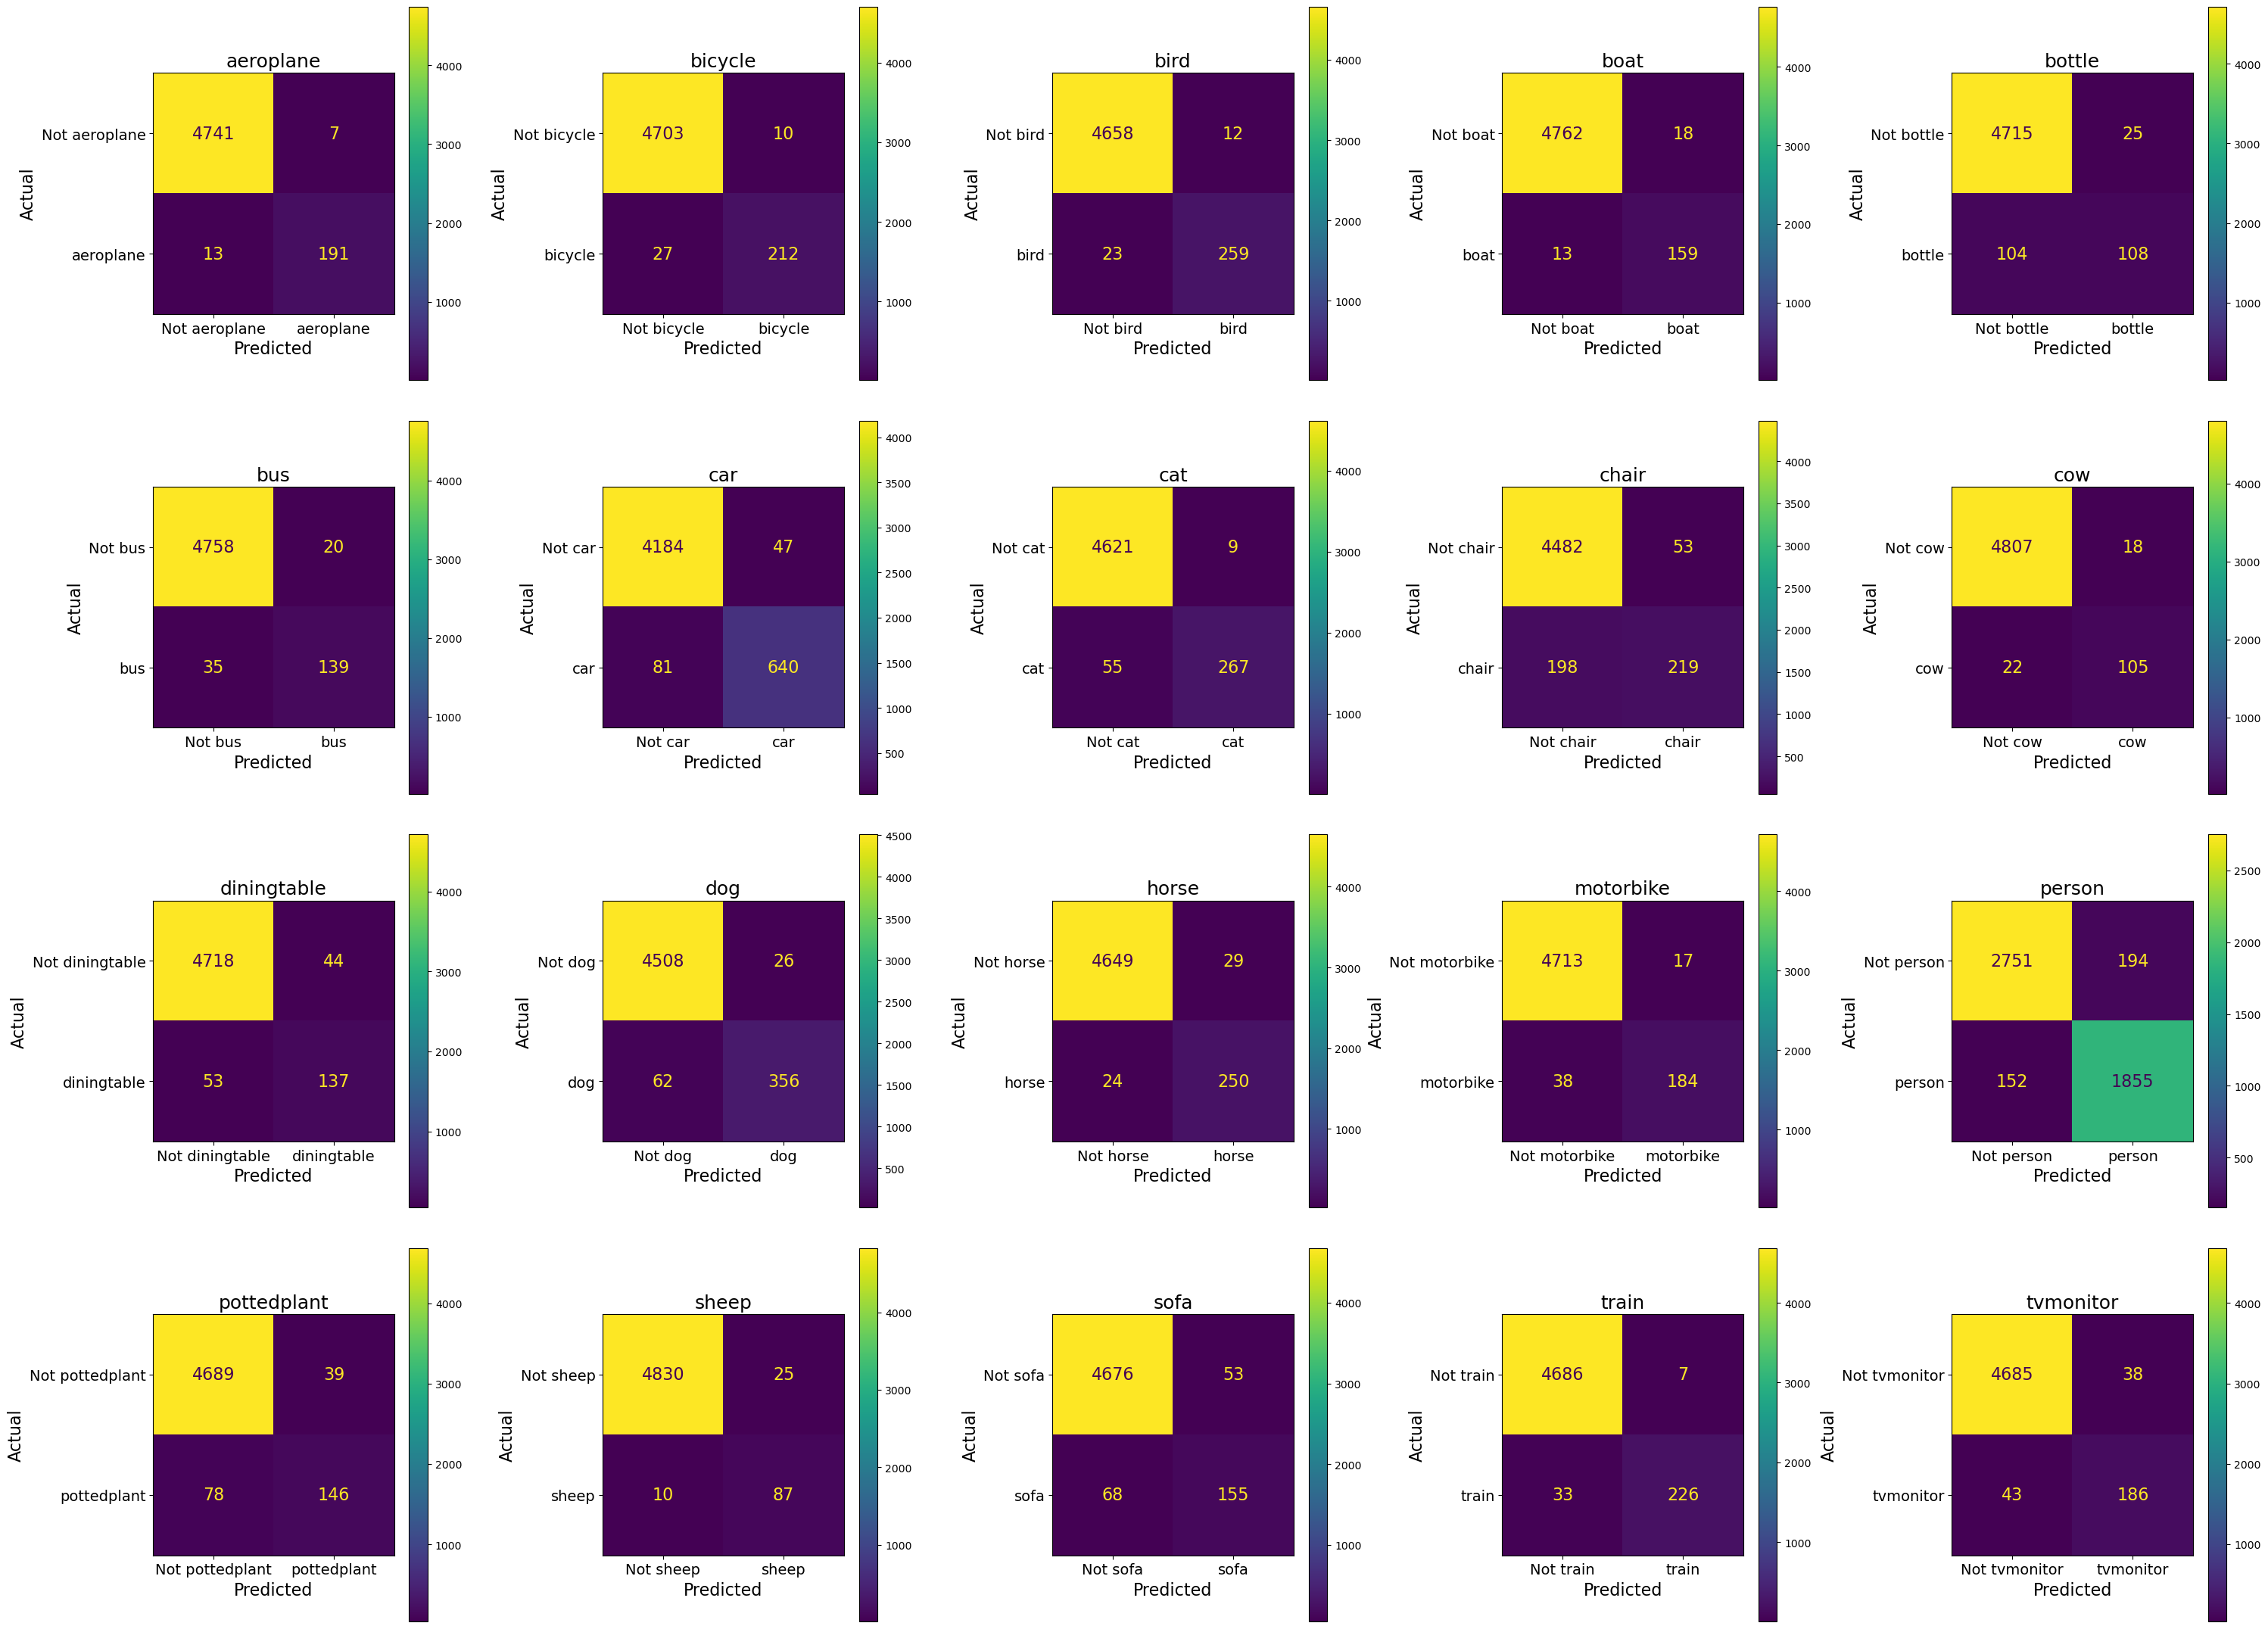

In [31]:
# Initialize the model
num_labels = 20
# model = CTranModel(num_labels=num_labels, use_lmt=True, pos_emb=True)
# model.load_state_dict(torch.load('best_model.pt'))
model = CTranModel(num_labels=num_labels, use_lmt=False, pos_emb=True)
model.load_state_dict(torch.load('best_model_withoutlmt.pt'))
model = model.cuda()
model.eval()
train_dataset = Voc07Dataset(img_dir=img_dir, anno_path=train_anno_path, image_transform=transform, labels_path=labels_path, known_labels=20)
valid_dataset = Voc07Dataset(img_dir=img_dir, anno_path=valid_anno_path, image_transform=transform, labels_path=labels_path, known_labels=20)
test_dataset = Voc07Dataset(img_dir=img_dir, anno_path=test_anno_path, image_transform=transform, labels_path=labels_path, known_labels=20)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Test function
def test_model(model, dataloader):
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].cuda()
            labels = batch['labels'].cpu().numpy()  # Move labels from GPU to CPU
            outputs, _, _ = model(images, mask=None)  # Get model output
            
            # Apply Sigmoid activation and convert output to binary predictions
            preds = torch.sigmoid(outputs).cpu().numpy()  # Move predictions from GPU to CPU
            preds = (preds > 0.5).astype(int)  # Threshold set to 0.5

            all_labels.extend(labels)
            all_preds.extend(preds)

    return np.array(all_labels), np.array(all_preds)

# Get predictions on the test dataset
labels, preds = test_model(model, test_loader)

# Calculate evaluation metrics for multi-label classification
# Here, precision, recall, and F1 score are calculated for each label and averaged
accuracy = (labels == preds).mean()  # Calculate accuracy in a multi-label setting
precision = precision_score(labels, preds, average='macro', zero_division=0)
recall = recall_score(labels, preds, average='macro', zero_division=0)
f1 = f1_score(labels, preds, average='macro', zero_division=0)

print("Test Accuracy: {:.4f}".format(accuracy))
print("Test Precision: {:.4f}".format(precision))
print("Test Recall: {:.4f}".format(recall))
print("Test F1 Score: {:.4f}".format(f1))


# Plot confusion matrix
def plot_confusion_matrix(labels, preds, class_names):
    # Calculate the confusion matrix for multi-label classification
    confusion_matrices = multilabel_confusion_matrix(labels, preds)
    
    # Adjust figure size to make each plot even larger
    fig, axes = plt.subplots(4, 5, figsize=(30, 22))  # Increased figure size
    axes = axes.ravel()
    
    for idx, (cm, label) in enumerate(zip(confusion_matrices, class_names)):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not " + label, label])
        disp.plot(ax=axes[idx], values_format="d")
        
        # Increase font sizes for better readability
        disp.ax_.set_title(label, fontsize=18)  # Increase title font size
        disp.ax_.tick_params(axis='both', which='major', labelsize=14)  # Increase tick label font size
        disp.ax_.set_xlabel('Predicted', fontsize=16)  # Increase x-axis label font size
        disp.ax_.set_ylabel('Actual', fontsize=16)  # Increase y-axis label font size
        
        # Adjust text size inside the confusion matrix cells
        for text in disp.ax_.texts:
            text.set_fontsize(16)  # Set font size of the text elements inside the matrix

    plt.tight_layout()
    plt.show()

# Get the list of class names (in the same order as in the dataset)
class_names = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
    'bus', 'car', 'cat', 'chair', 'cow', 
    'diningtable', 'dog', 'horse', 'motorbike', 'person', 
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

# Plot the confusion matrix
plot_confusion_matrix(labels, preds, class_names)


#### Training Process of Transformers model with LMT

In [ ]:
known_labels=15
train_dataset = Voc07Dataset(img_dir=img_dir, anno_path=train_anno_path, image_transform=transform, labels_path=labels_path, known_labels=known_labels)
valid_dataset = Voc07Dataset(img_dir=img_dir, anno_path=valid_anno_path, image_transform=transform, labels_path=labels_path, known_labels=20)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

# Initialize the model
num_labels = 20
model = CTranModel(num_labels=num_labels, use_lmt=True, pos_emb=True).cuda()

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Define train and evaluation functions for masked training with the adapted loss function
def train_mask_epoch(model, dataloader, optimizer, criterion, epoch, train=True, max_samples=None):
    if train:
        model.train()
        optimizer.zero_grad()
    else:
        model.eval()

    all_predictions = torch.zeros(len(dataloader.dataset), num_labels).cpu()
    all_targets = torch.zeros(len(dataloader.dataset), num_labels).cpu()
    all_masks = torch.zeros(len(dataloader.dataset), num_labels).cpu()
    all_image_ids = []

    loss_total = 0
    batch_idx = 0

    for batch in tqdm(dataloader, desc=f'Epoch {epoch}', leave=False, ncols=50):
        if max_samples and batch_idx == max_samples:
            break

        images = batch['image'].cuda()
        labels = batch['labels'].float().cuda()
        mask = batch['mask'].float().cuda()
        unk_mask = custom_replace(mask, 1, 0, 0)

        all_image_ids += batch['imageIDs']

        if train:
            optimizer.zero_grad()
            outputs, _, _ = model(images, mask)
        else:
            with torch.no_grad():
                outputs, _, _ = model(images, mask)

        # Custom loss function using only unknown labels for masked loss calculation
        loss = criterion(outputs.view(labels.size(0), -1), labels)
        loss = (unk_mask * loss).sum() / unk_mask.sum().item()

        if train:
            loss.backward()
            optimizer.step()

        loss_total += loss.item()

        start_idx = batch_idx * dataloader.batch_size
        end_idx = start_idx + images.size(0)
        all_predictions[start_idx:end_idx] = outputs.data.cpu()
        all_targets[start_idx:end_idx] = labels.data.cpu()
        all_masks[start_idx:end_idx] = mask.data.cpu()
        
        batch_idx += 1

    avg_loss = loss_total / len(dataloader)
    return all_predictions, all_targets, all_masks, all_image_ids, avg_loss

# Training loop
num_epochs = 20
best_val_loss = float('inf')
log_file = 'training_log_custom.txt'

with open(log_file, 'w') as f:
    f.write("Epoch\tTrain Loss\tValidation Loss\n")

for epoch in range(num_epochs):
    # Train and validate for each epoch
    _, _, _, _, train_loss = train_mask_epoch(model, train_loader, optimizer, criterion, epoch, train=True)
    _, _, _, _, val_loss = train_mask_epoch(model, valid_loader, optimizer, criterion, epoch, train=False)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.7f}, Validation Loss: {val_loss:.7f}")
    with open(log_file, 'a') as f:
        f.write(f"{epoch+1}\t{train_loss:.7f}\t{val_loss:.7f}\n")

    # Save the model with the lowest validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'best_model_with_custom_{known_labels}.pt')
        print(f"Model saved with validation loss: {val_loss:.7f}")

print("Training complete.")

c:\Users\56372\anaconda3\envs\ece60146\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\56372\anaconda3\envs\ece60146\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Train Loss: 0.0881353, Validation Loss: 0.0420157
Model saved with validation loss: 0.0420157


Epoch [2/20], Train Loss: 0.0401245, Validation Loss: 0.0332426
Model saved with validation loss: 0.0332426


Epoch [3/20], Train Loss: 0.0290494, Validation Loss: 0.0230429
Model saved with validation loss: 0.0230429


Epoch [4/20], Train Loss: 0.0223229, Validation Loss: 0.0152904
Model saved with validation loss: 0.0152904


Epoch [5/20], Train Loss: 0.0156276, Validation Loss: 0.0100849
Model saved with validation loss: 0.0100849


Epoch [6/20], Train Loss: 0.0122985, Validation Loss: 0.0091383
Model saved with validation loss: 0.0091383


Epoch [7/20], Train Loss: 0.0090601, Validation Loss: 0.0070916
Model saved with validation loss: 0.0070916


Epoch [8/20], Train Loss: 0.0079213, Validation Loss: 0.0048362
Model saved with validation loss: 0.0048362


Epoch [9/20], Train Loss: 0.0068033, Validation Loss: 0.0041533
Model saved with validation loss: 0.0041533


Epoch [10/20], Train Loss: 0.0066471, Validation Loss: 0.0064275


Epoch [11/20], Train Loss: 0.0045730, Validation Loss: 0.0031301
Model saved with validation loss: 0.0031301


Epoch [12/20], Train Loss: 0.0052267, Validation Loss: 0.0035476


Epoch [13/20], Train Loss: 0.0049034, Validation Loss: 0.0020325
Model saved with validation loss: 0.0020325


Epoch [14/20], Train Loss: 0.0045886, Validation Loss: 0.0024337


Epoch [15/20], Train Loss: 0.0046457, Validation Loss: 0.0022922


Epoch [16/20], Train Loss: 0.0036923, Validation Loss: 0.0022339


Epoch [17/20], Train Loss: 0.0027526, Validation Loss: 0.0030290


Epoch [18/20], Train Loss: 0.0032687, Validation Loss: 0.0022557


Epoch [19/20], Train Loss: 0.0037484, Validation Loss: 0.0032757


Epoch [20/20], Train Loss: 0.0036583, Validation Loss: 0.0017921
Model saved with validation loss: 0.0017921
Training complete.


#### Display the trianing process of Transformers model with LMT

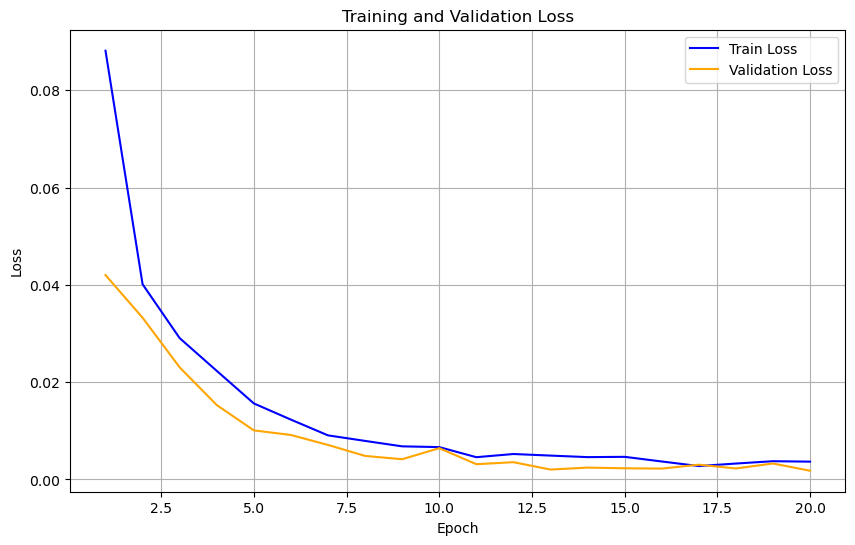

In [25]:
# Read the training log file
# Initialize lists to store losses and epochs
train_losses = []
val_losses = []
epochs = []

# Read the training log file
log_file = 'training_log_custom.txt'
with open(log_file, 'r') as f:
    next(f)  # Skip the header
    for line in f:
        epoch, train_loss, val_loss = line.strip().split('\t')
        epochs.append(int(epoch))
        train_losses.append(float(train_loss))
        val_losses.append(float(val_loss))

# Plot both training and validation losses on the same figure
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

#### Test the Transformers model with LMT based on unmaksed dataset

c:\Users\56372\anaconda3\envs\ece60146\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\56372\anaconda3\envs\ece60146\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model with LMS:
Accuracy: 0.9784, Precision: 0.8639, Recall: 0.7641, F1 Score: 0.8055


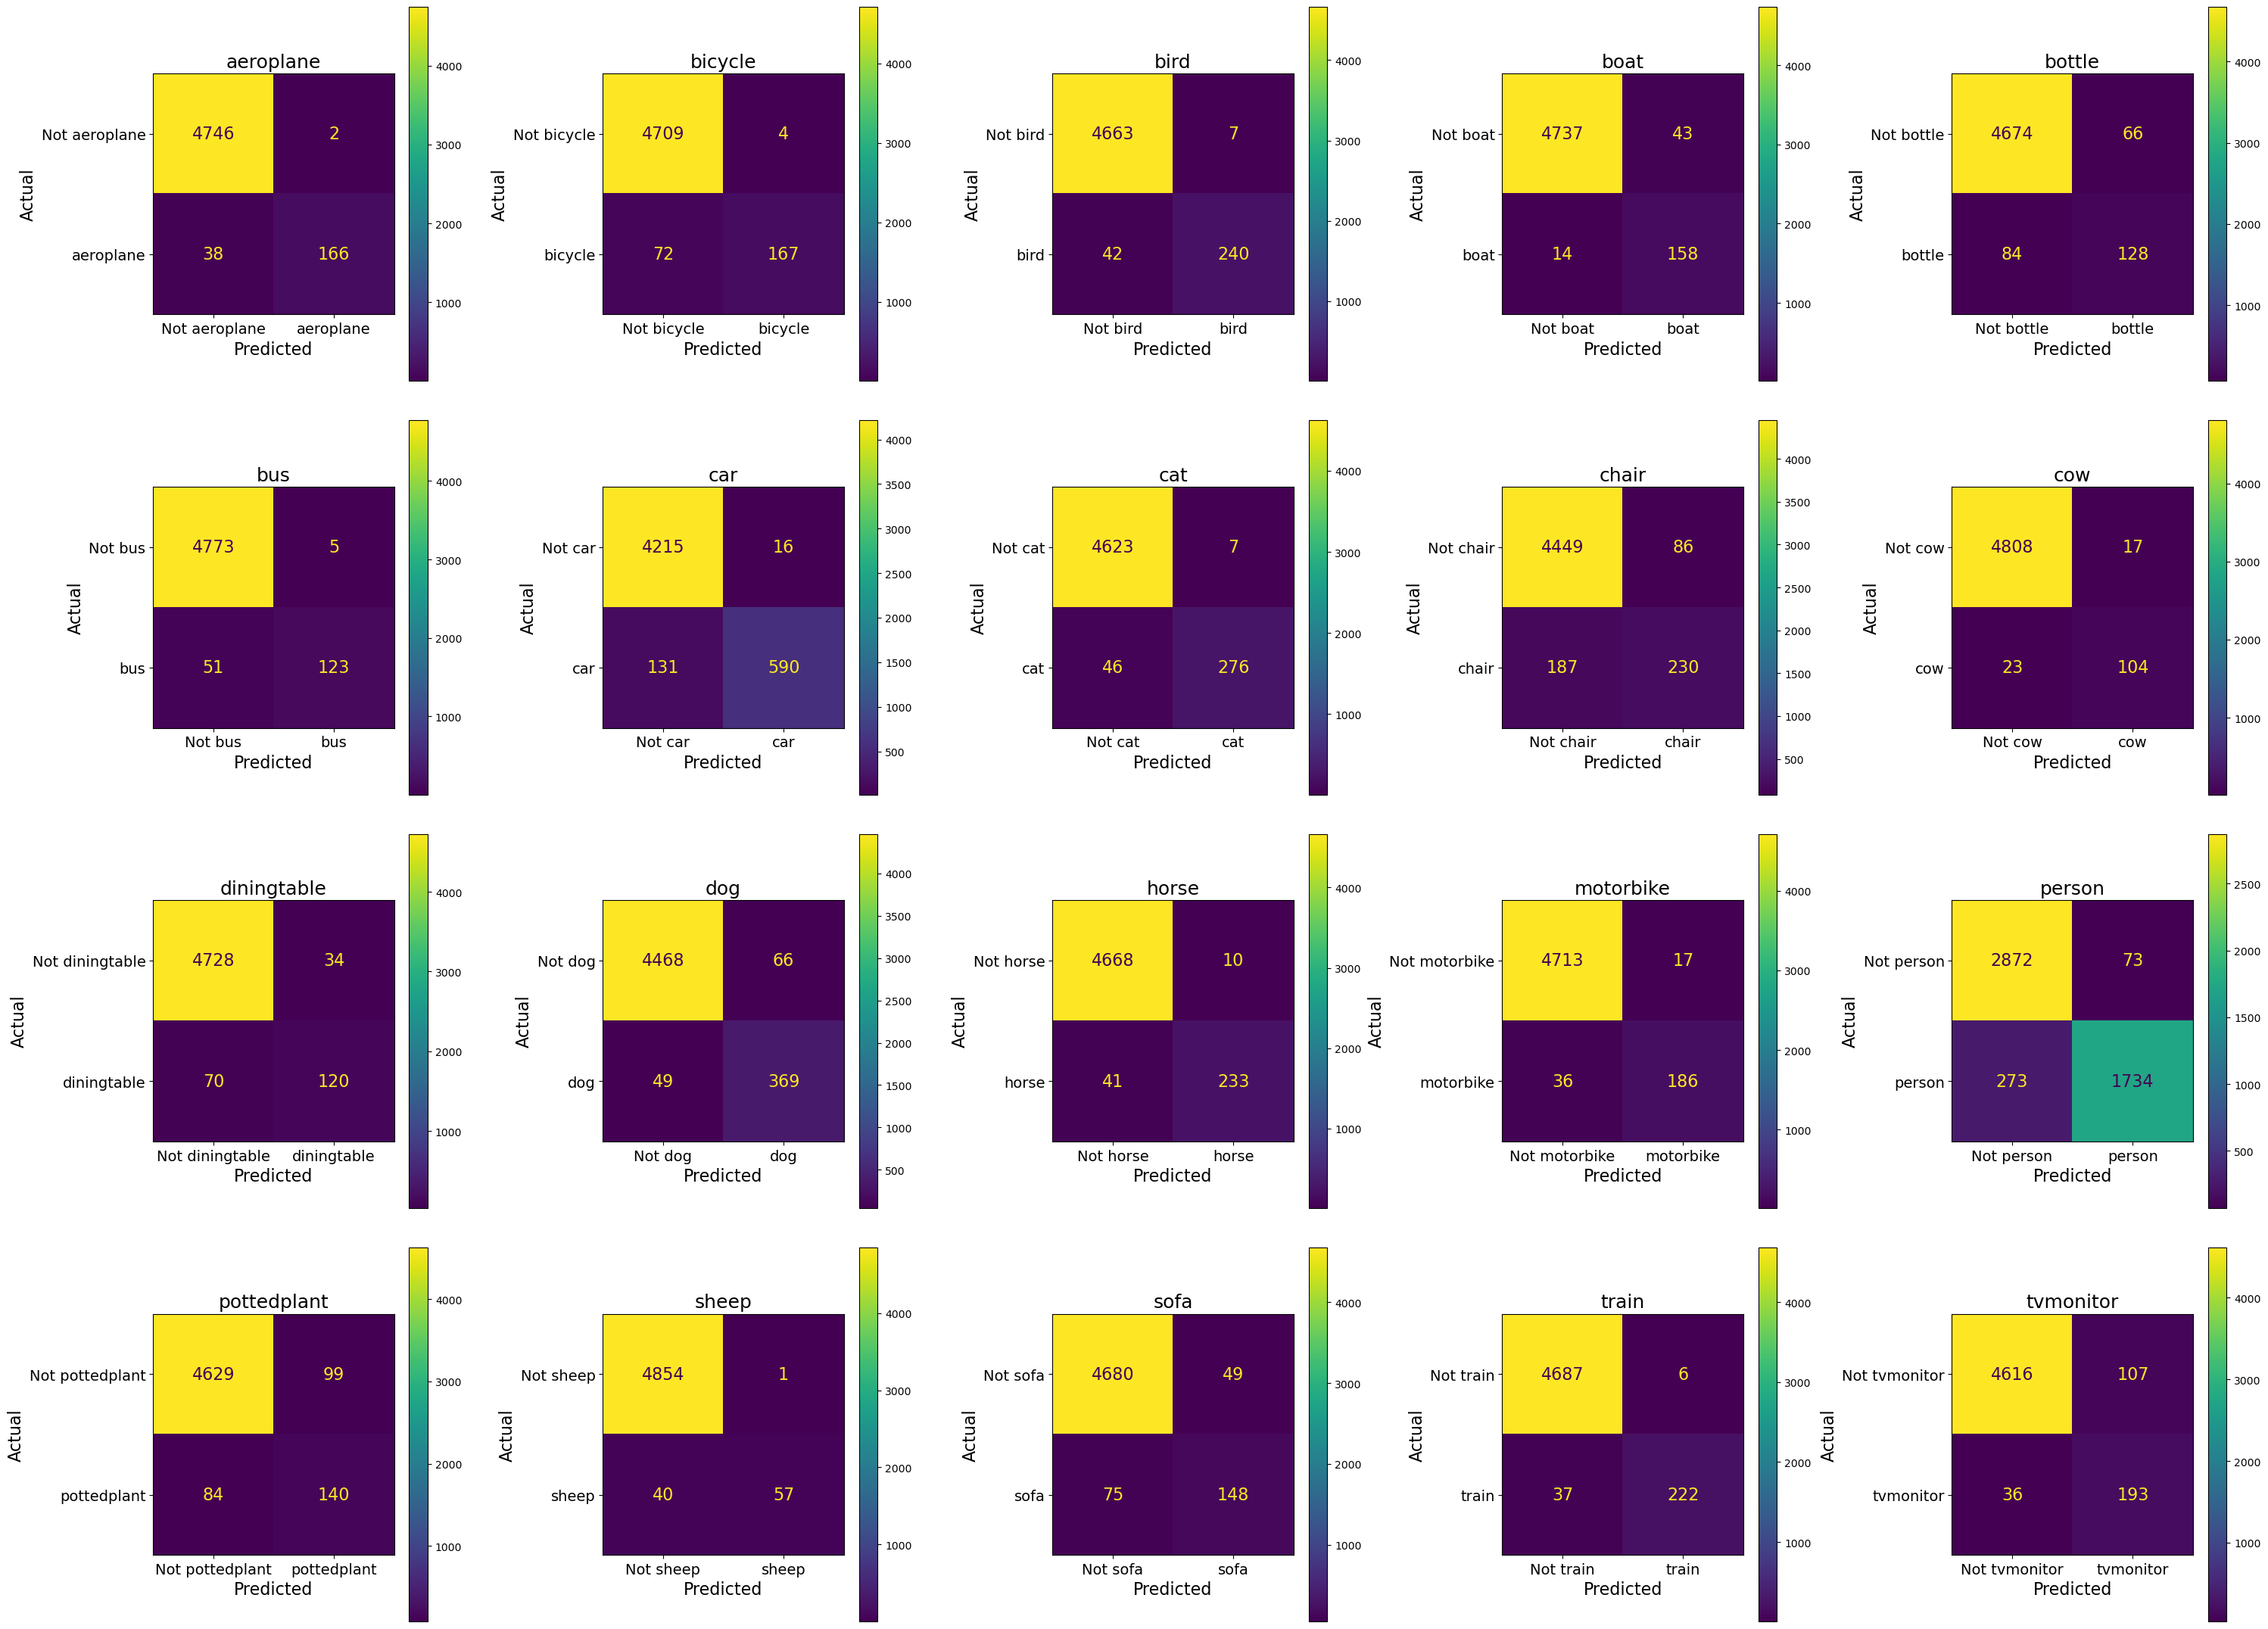

In [ ]:
# train_dataset = Voc07Dataset(img_dir=img_dir, anno_path=train_anno_path, image_transform=transform, labels_path=labels_path, known_labels=1)
# valid_dataset = Voc07Dataset(img_dir=img_dir, anno_path=valid_anno_path, image_transform=transform, labels_path=labels_path, known_labels=1)
test_dataset = Voc07Dataset(img_dir=img_dir, anno_path=test_anno_path, image_transform=transform, labels_path=labels_path, known_labels=20)

# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
# Initialize model
num_labels = 20

# Load two models, one with masking (LMS) and one without
model_with_lms = CTranModel(num_labels=num_labels, use_lmt=True, pos_emb=True)
model_with_lms.load_state_dict(torch.load(f'best_model_with_custom_{known_labels}.pt'))
model_with_lms = model_with_lms.cuda()
model_with_lms.eval()

def test_model_mask(model, dataloader):
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].cuda()
            labels = batch['labels'].cpu().numpy()  # Move labels to CPU
            mask = batch['mask'].cuda()  # Use mask if available、

            outputs, _, _ = model(images, mask=None)  # Get model outputs
            
            # Apply Sigmoid activation and convert to binary predictions
            preds = torch.sigmoid(outputs).cpu().numpy()
            preds = (preds > 0.5).astype(int)  # Threshold at 0.5

            all_labels.extend(labels)
            all_preds.extend(preds)

    return np.array(all_labels), np.array(all_preds)
# Get predictions on the test dataset
labels, preds_with_lms = test_model_mask(model_with_lms, test_loader)

# Calculate metrics for multi-label classification
def calculate_metrics(labels, preds):
    accuracy = (labels == preds).mean()
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)
    return accuracy, precision, recall, f1

# Calculate and print metrics for the model with LMS
metrics_with_lms = calculate_metrics(labels, preds_with_lms)

print("Model with LMS:")
print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(*metrics_with_lms))

def plot_confusion_matrix(labels, preds, class_names):
    # Calculate the confusion matrix for multi-label classification
    confusion_matrices = multilabel_confusion_matrix(labels, preds)
    
    # Adjust figure size to make each plot even larger
    fig, axes = plt.subplots(4, 5, figsize=(30, 22))  # Increased figure size
    axes = axes.ravel()
    
    for idx, (cm, label) in enumerate(zip(confusion_matrices, class_names)):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not " + label, label])
        disp.plot(ax=axes[idx], values_format="d")
        
        # Increase font sizes for better readability
        disp.ax_.set_title(label, fontsize=18)  # Increase title font size
        disp.ax_.tick_params(axis='both', which='major', labelsize=14)  # Increase tick label font size
        disp.ax_.set_xlabel('Predicted', fontsize=16)  # Increase x-axis label font size
        disp.ax_.set_ylabel('Actual', fontsize=16)  # Increase y-axis label font size
        
        # Adjust text size inside the confusion matrix cells
        for text in disp.ax_.texts:
            text.set_fontsize(16)  # Set font size of the text elements inside the matrix

    plt.tight_layout()
    plt.show()
# Get the list of class names (in the same order as in the dataset)
class_names = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
    'bus', 'car', 'cat', 'chair', 'cow', 
    'diningtable', 'dog', 'horse', 'motorbike', 'person', 
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

# Plot the confusion matrix for the model with LMS
plot_confusion_matrix(labels, preds_with_lms, class_names)


### Test Transformers model with LMT based on the masked data

c:\Users\56372\anaconda3\envs\ece60146\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\56372\anaconda3\envs\ece60146\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model with LMT:
Accuracy: 0.9969, Precision: 0.9594, Recall: 0.9846, F1 Score: 0.9713


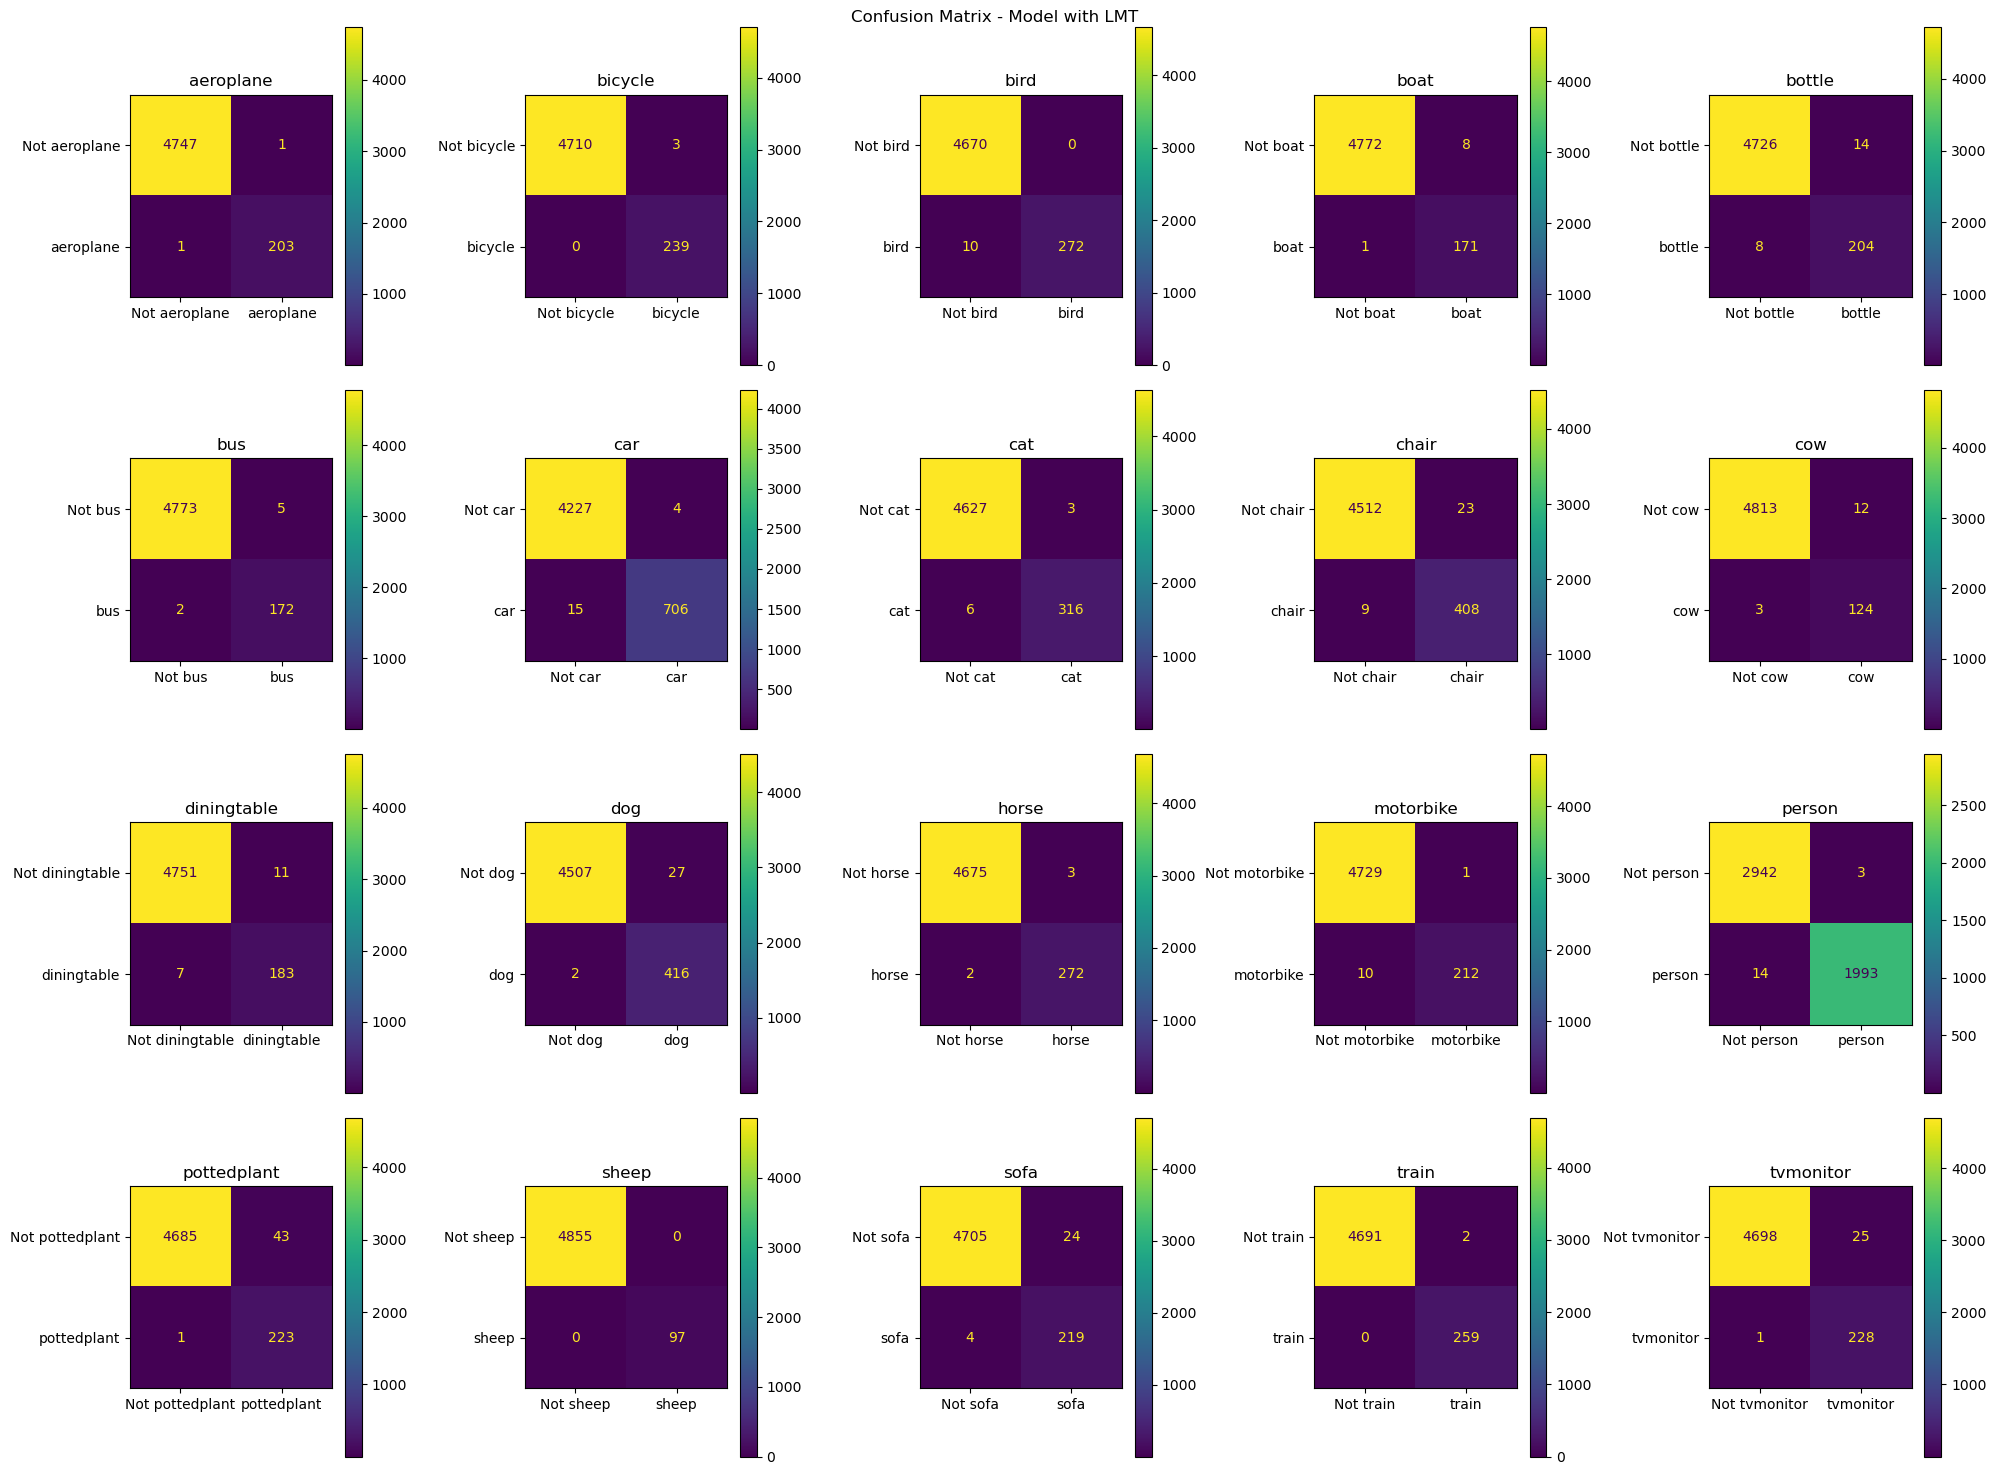

In [ ]:
# Set up dataset and data loaders
img_dir = 'voc/voc/VOCdevkit/VOC2007/JPEGImages'
labels_path = 'voc/voc/VOCdevkit/VOC2007/Annotations'
train_anno_path = 'voc/voc/VOCdevkit/VOC2007/ImageSets/Main/trainval.txt'
valid_anno_path = 'voc/voc/VOCdevkit/VOC2007/ImageSets/Main/val.txt'
test_anno_path = 'voc/voc/VOCdevkit/VOC2007/ImageSets/Main/test.txt'

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and data loaders
test_dataset = Voc07Dataset(img_dir=img_dir, anno_path=test_anno_path, image_transform=transform, labels_path=labels_path, known_labels=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize model
num_labels = 20

# Load model trained with mask (LMT)
model_with_lmt = CTranModel(num_labels=num_labels, use_lmt=True, pos_emb=True)
model_with_lmt.load_state_dict(torch.load(f'best_model_with_custom_{known_labels}.pt'))
model_with_lmt = model_with_lmt.cuda()
model_with_lmt.eval()

# Test function
def test_model(model, dataloader, mask=None):
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].cuda()
            labels = batch['labels'].cpu().numpy()  # Move labels from GPU to CPU
            mask_data = batch['mask'].cuda() if mask else None  # Apply mask if available

            outputs, _, _ = model(images, mask=mask_data)  # Get model outputs
            
            # Apply Sigmoid activation and convert to binary predictions
            preds = torch.sigmoid(outputs).cpu().numpy()
            preds = (preds > 0.5).astype(int)  # Threshold at 0.5

            all_labels.extend(labels)
            all_preds.extend(preds)

    return np.array(all_labels), np.array(all_preds)

# Calculate metrics for multi-label classification
def calculate_metrics(labels, preds):
    accuracy = (labels == preds).mean()
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)
    return accuracy, precision, recall, f1

# Get predictions and metrics for the model with LMT
labels, preds_with_lmt = test_model(model_with_lmt, test_loader, mask=True)
metrics_with_lmt = calculate_metrics(labels, preds_with_lmt)

print("Model with LMT:")
print("Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(*metrics_with_lmt))

# Plot confusion matrix
def plot_confusion_matrix(labels, preds, class_names, title):
    confusion_matrices = multilabel_confusion_matrix(labels, preds)
    
    fig, axes = plt.subplots(4, 5, figsize=(20, 15))
    axes = axes.ravel()
    
    for idx, (cm, label) in enumerate(zip(confusion_matrices, class_names)):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not " + label, label])
        disp.plot(ax=axes[idx], values_format="d")
        disp.ax_.set_title(label)
        disp.ax_.set_xlabel('')
        disp.ax_.set_ylabel('')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Class names
class_names = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
    'bus', 'car', 'cat', 'chair', 'cow', 
    'diningtable', 'dog', 'horse', 'motorbike', 'person', 
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

# Plot confusion matrix for the model with LMT
plot_confusion_matrix(labels, preds_with_lmt, class_names, "Confusion Matrix - Model with LMT")


### Contradistinction between the CTran model and Normale model_Resnet

c:\Users\56372\anaconda3\envs\ece60146\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\56372\anaconda3\envs\ece60146\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 0.1337203, Validation Loss: 0.0857457
Model saved with validation loss: 0.0857457
Epoch [2/10], Train Loss: 0.0933083, Validation Loss: 0.0550600
Model saved with validation loss: 0.0550600
Epoch [3/10], Train Loss: 0.0758235, Validation Loss: 0.0453916
Model saved with validation loss: 0.0453916
Epoch [4/10], Train Loss: 0.0637033, Validation Loss: 0.0411697
Model saved with validation loss: 0.0411697
Epoch [5/10], Train Loss: 0.0551776, Validation Loss: 0.0284683
Model saved with validation loss: 0.0284683
Epoch [6/10], Train Loss: 0.0449255, Validation Loss: 0.0244482
Model saved with validation loss: 0.0244482
Epoch [7/10], Train Loss: 0.0401618, Validation Loss: 0.0232273
Model saved with validation loss: 0.0232273
Epoch [8/10], Train Loss: 0.0369825, Validation Loss: 0.0237693
Epoch [9/10], Train Loss: 0.0331970, Validation Loss: 0.0158233
Model saved with validation loss: 0.0158233
Epoch [10/10], Train Loss: 0.0294043, Validation Loss: 0.0147047
Model s

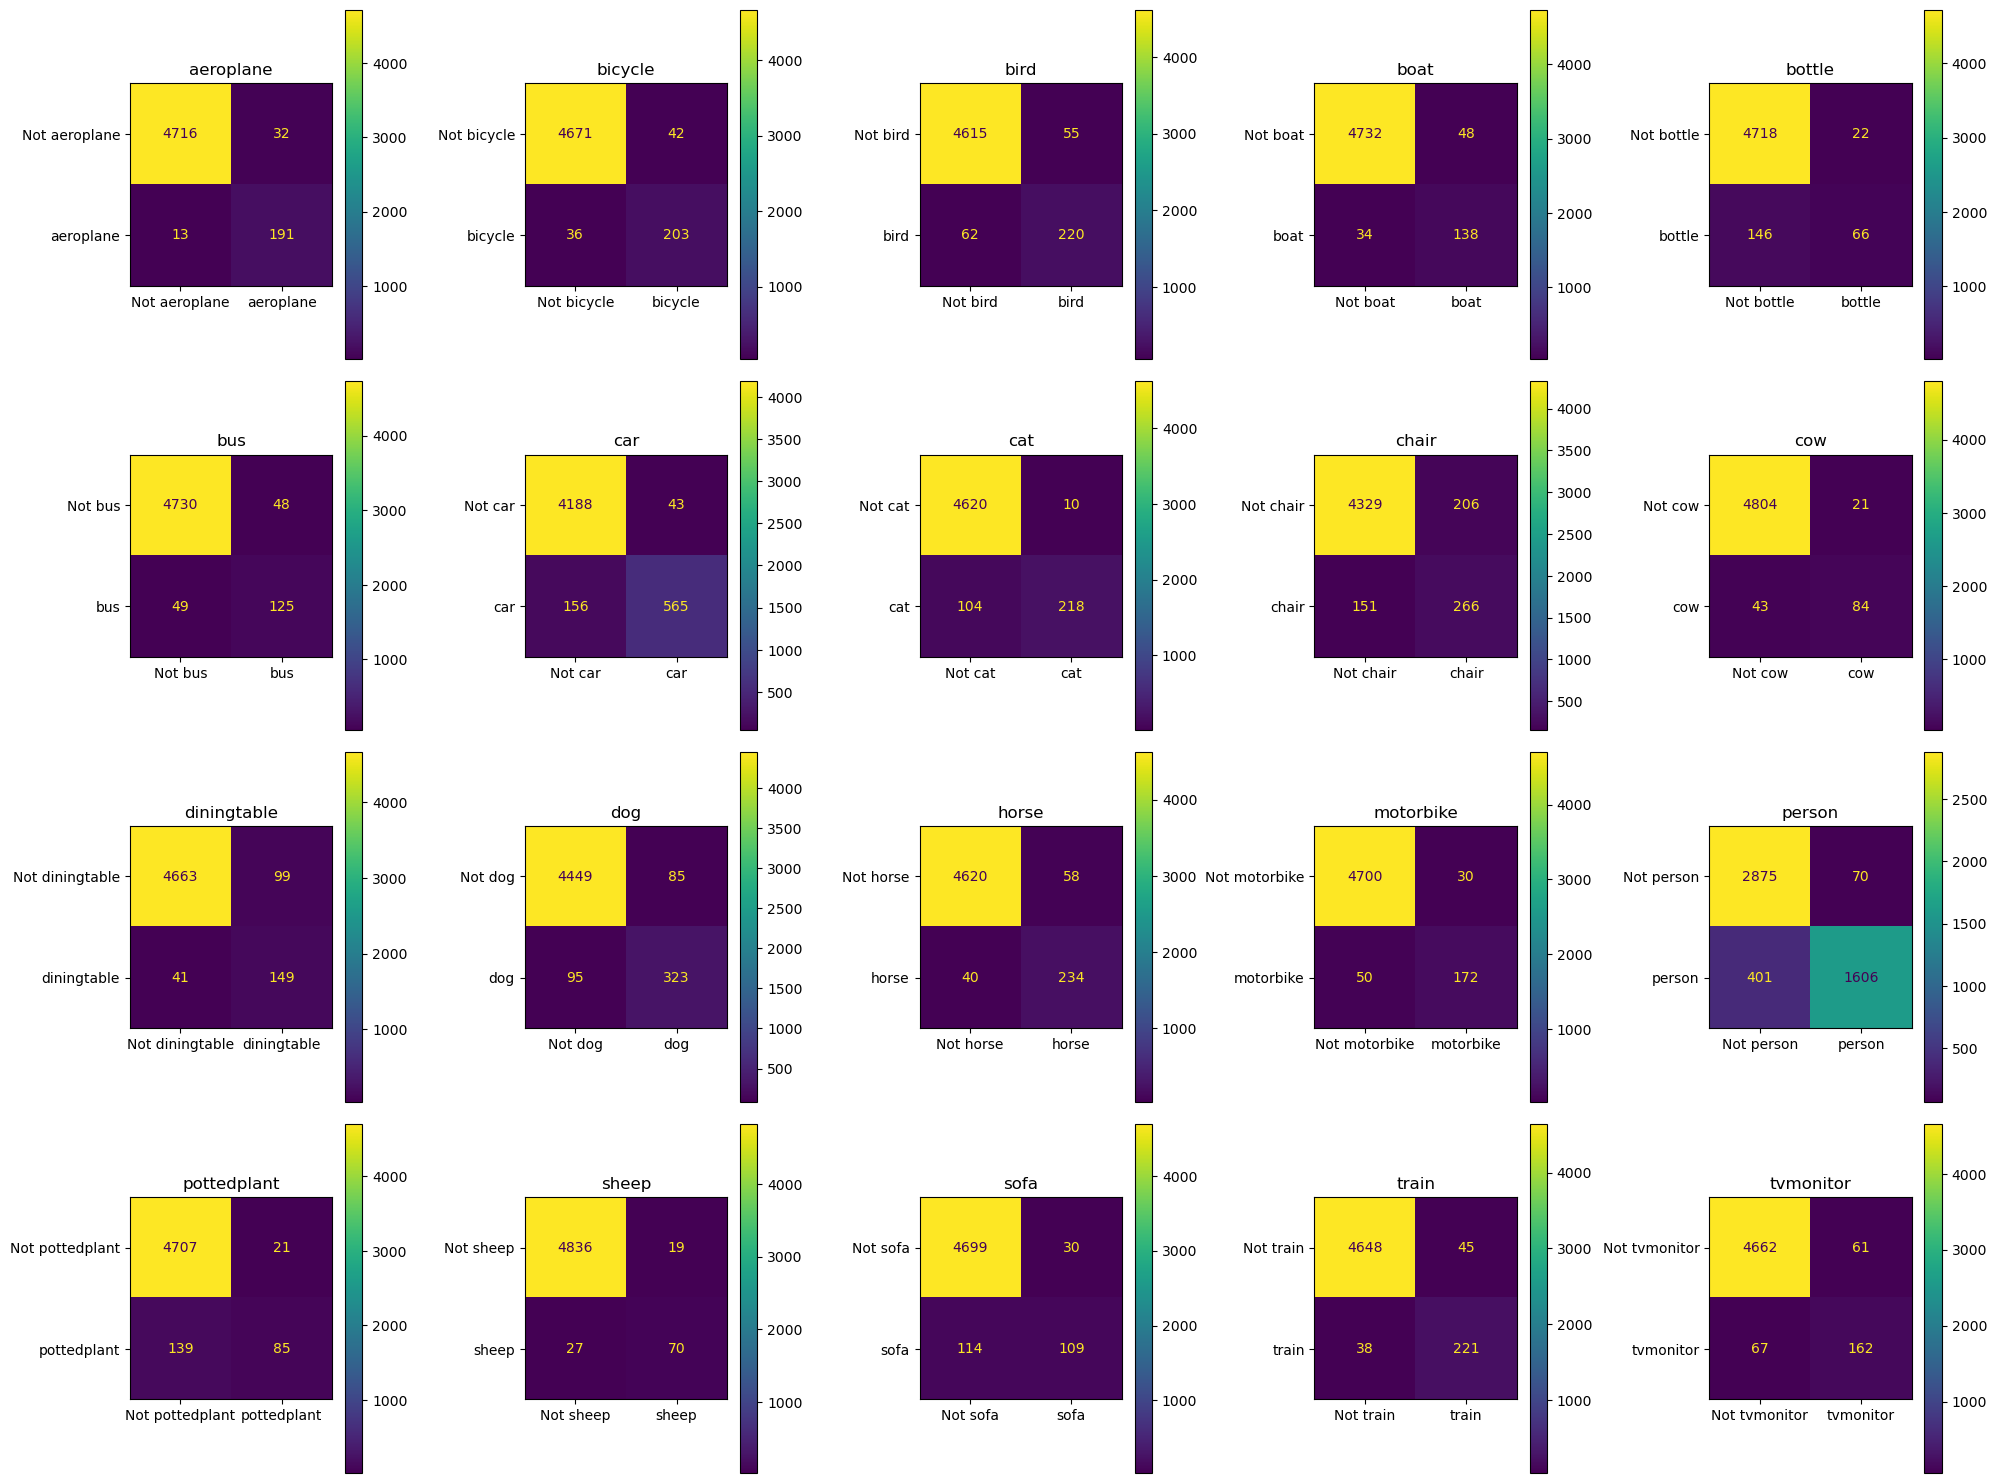

In [ ]:
# Dataset paths
img_dir = 'voc/voc/VOCdevkit/VOC2007/JPEGImages'
labels_path = 'voc/voc/VOCdevkit/VOC2007/Annotations'
train_anno_path = 'voc/voc/VOCdevkit/VOC2007/ImageSets/Main/trainval.txt'
valid_anno_path = 'voc/voc/VOCdevkit/VOC2007/ImageSets/Main/val.txt'
test_anno_path = 'voc/voc/VOCdevkit/VOC2007/ImageSets/Main/test.txt'

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Set up datasets and data loaders
train_dataset = Voc07Dataset(img_dir=img_dir, anno_path=train_anno_path, image_transform=transform, labels_path=labels_path, known_labels=20)
valid_dataset = Voc07Dataset(img_dir=img_dir, anno_path=valid_anno_path, image_transform=transform, labels_path=labels_path, known_labels=20)
test_dataset = Voc07Dataset(img_dir=img_dir, anno_path=test_anno_path, image_transform=transform, labels_path=labels_path, known_labels=20)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Define ResNet101 model and modify the last layer
class ResNet101Baseline(nn.Module):
    def __init__(self, num_labels=20):
        super(ResNet101Baseline, self).__init__()
        self.base_model = models.resnet101(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_labels)

    def forward(self, x):
        return self.base_model(x)

# Initialize ResNet101 model
model_resnet101 = ResNet101Baseline(num_labels=num_labels).cuda()

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_resnet101.parameters(), lr=1e-4)

# Training and evaluation functions
def train_one_epoch_resnet(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        images = batch['image'].cuda()
        labels = batch['labels'].cuda()

        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    avg_loss = running_loss / len(dataloader)
    return avg_loss

def evaluate_resnet(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].cuda()
            labels = batch['labels'].cpu().numpy()

            outputs = model(images)
            loss = criterion(outputs, torch.tensor(labels).cuda())
            running_loss += loss.item()

            preds = torch.sigmoid(outputs).cpu().numpy()
            preds = (preds > 0.5).astype(int)
            all_labels.extend(labels)
            all_preds.extend(preds)

    avg_loss = running_loss / len(dataloader)
    accuracy = accuracy_score(np.array(all_labels), np.array(all_preds))
    precision = precision_score(np.array(all_labels), np.array(all_preds), average='macro', zero_division=0)
    recall = recall_score(np.array(all_labels), np.array(all_preds), average='macro', zero_division=0)
    f1 = f1_score(np.array(all_labels), np.array(all_preds), average='macro', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1

# Training loop
num_epochs = 20
best_val_loss = float('inf')
for epoch in range(num_epochs):
    train_loss = train_one_epoch_resnet(model_resnet101, train_loader, criterion, optimizer)
    val_loss, accuracy, precision, recall, f1 = evaluate_resnet(model_resnet101, valid_loader, criterion)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.7f}, Validation Loss: {val_loss:.7f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_resnet101.state_dict(), 'best_resnet101_model.pt')
        print("Model saved with validation loss: {:.7f}".format(best_val_loss))

print("Training complete.")

# Load best model and evaluate on the test set
model_resnet101.load_state_dict(torch.load('best_resnet101_model.pt'))
model_resnet101.eval()

def test_model_resnet(model, dataloader):
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].cuda()
            labels = batch['labels'].cpu().numpy()
            outputs = model(images)
            
            preds = torch.sigmoid(outputs).cpu().numpy()
            preds = (preds > 0.5).astype(int)

            all_labels.extend(labels)
            all_preds.extend(preds)

    return np.array(all_labels), np.array(all_preds)

# Get predictions on the test dataset
labels, preds = test_model_resnet(model_resnet101, test_loader)

# Calculate test set metrics
accuracy = (labels == preds).mean()
precision = precision_score(labels, preds, average='macro', zero_division=0)
recall = recall_score(labels, preds, average='macro', zero_division=0)
f1 = f1_score(labels, preds, average='macro', zero_division=0)

print("Test Accuracy: {:.4f}".format(accuracy))
print("Test Precision: {:.4f}".format(precision))
print("Test Recall: {:.4f}".format(recall))
print("Test F1 Score: {:.4f}".format(f1))

# Plot confusion matrix
def plot_confusion_matrix(labels, preds, class_names):
    confusion_matrices = multilabel_confusion_matrix(labels, preds)
    
    fig, axes = plt.subplots(4, 5, figsize=(20, 15))
    axes = axes.ravel()
    
    for idx, (cm, label) in enumerate(zip(confusion_matrices, class_names)):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not " + label, label])
        disp.plot(ax=axes[idx], values_format="d")
        disp.ax_.set_title(label)
        disp.ax_.set_xlabel('')
        disp.ax_.set_ylabel('')
    
    plt.tight_layout()
    plt.show()

# Class names for VOC dataset
class_names = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
    'bus', 'car', 'cat', 'chair', 'cow', 
    'diningtable', 'dog', 'horse', 'motorbike', 'person', 
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

# Plot confusion matrix for the ResNet101 model
plot_confusion_matrix(labels, preds, class_names)

#### Display T-SNE figure

c:\Users\56372\anaconda3\envs\ece60146\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\56372\anaconda3\envs\ece60146\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


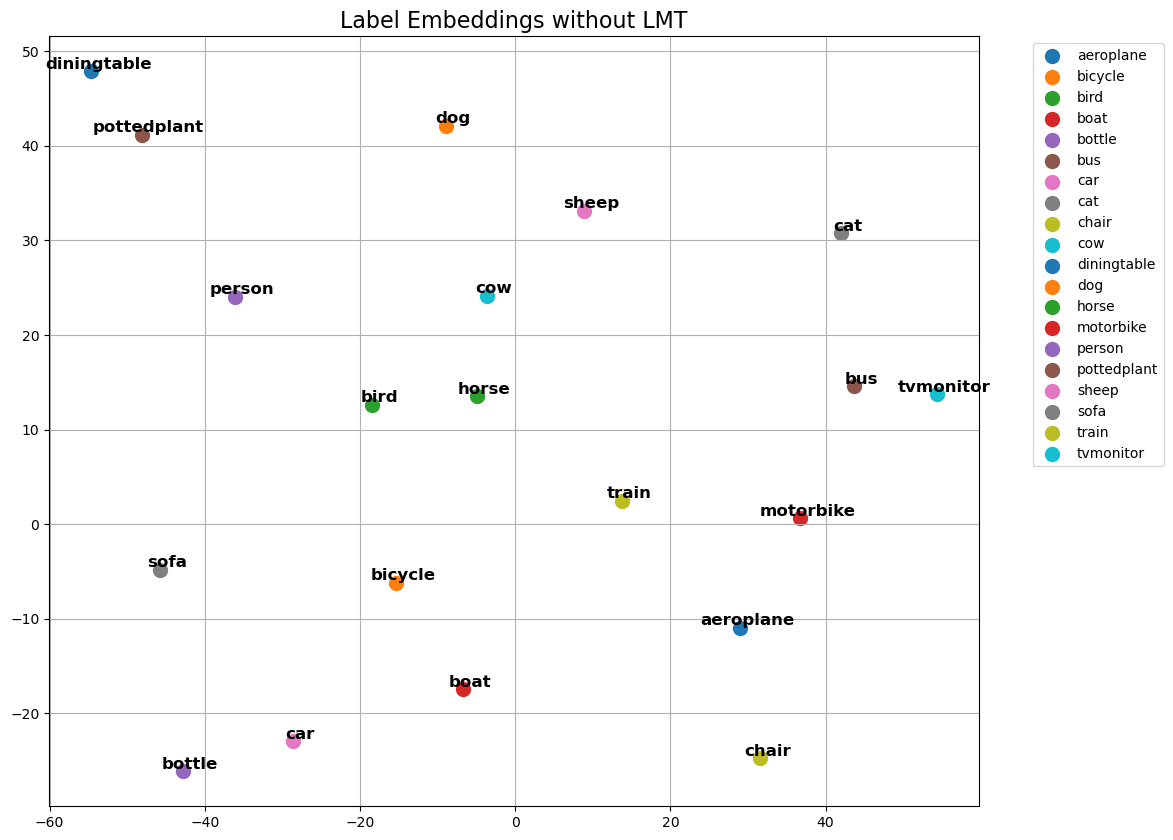

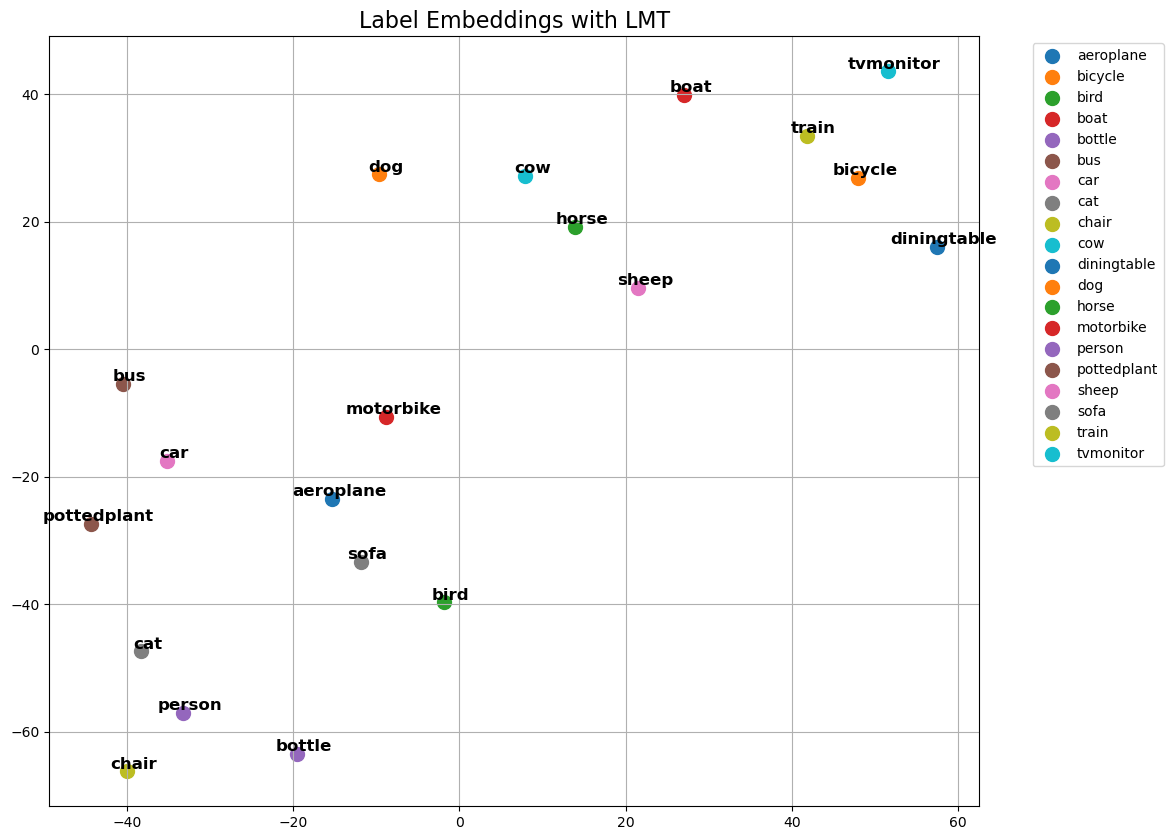

In [ ]:
# Define class names list (in the same order as in the dataset)
class_names = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
    'bus', 'car', 'cat', 'chair', 'cow', 
    'diningtable', 'dog', 'horse', 'motorbike', 'person', 
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
# Get label embeddings
def get_label_embeddings(model):
    with torch.no_grad():
        label_input = model.label_input.cuda()
        label_embeddings = model.label_lt(label_input).squeeze(0)  # Retrieve label embeddings
        return label_embeddings.cpu().numpy()
num_labels = 20
# Initialize model (without LMT)
model_without_lmt = CTranModel(num_labels=num_labels, use_lmt=False, pos_emb=True)
model_without_lmt.load_state_dict(torch.load('best_model_withoutlmt.pt'))
model_without_lmt = model_without_lmt.cuda()
model_without_lmt.eval()
embeddings_without_lmt = get_label_embeddings(model_without_lmt)
# Initialize model (with LMT)
model_with_lmt = CTranModel(num_labels=num_labels, use_lmt=True, pos_emb=True)
model_with_lmt.load_state_dict(torch.load(f'best_model_with_custom_{known_labels}.pt'))
model_with_lmt = model_with_lmt.cuda()
model_with_lmt.eval()

embeddings_with_lmt = get_label_embeddings(model_with_lmt)

# Use t-SNE for dimensionality reduction
# Set a small perplexity value for t-SNE
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
embeddings_2d_without_lmt = tsne.fit_transform(embeddings_without_lmt)
embeddings_2d_with_lmt = tsne.fit_transform(embeddings_with_lmt)


# Visualization function
def plot_embeddings(embeddings, title, class_names):
    plt.figure(figsize=(12, 10))  # Increased figure size
    for i, label in enumerate(class_names):
        x, y = embeddings[i]
        plt.scatter(x, y, label=label, s=100)  # Increased scatter point size
        plt.annotate(
            label,
            (x, y),
            textcoords="offset points",
            xytext=(5, 2),
            ha='center',
            fontsize=12,  # Increased annotation font size
            weight='bold'  # Make text bold
        )
    plt.title(title, fontsize=16)  # Increased title font size
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)  # Increased legend font size
    plt.grid()
    plt.show()

# Plot label embeddings without LMT
plot_embeddings(embeddings_2d_without_lmt, "Label Embeddings without LMT", class_names)

# Plot label embeddings with LMT
plot_embeddings(embeddings_2d_with_lmt, "Label Embeddings with LMT", class_names)